# Nowy Model Lekarz

## Cel Notebooka
Celem tego notebooka jest przeprowadzenie kompleksowej analizy danych dotyczących modelu 'Lekarz'.
Notebook został przygotowany jako przewodnik, który prowadzi od instalacji zależności, przez importy, wczytanie danych, ich przetwarzanie, analizę normalności, budowę modeli regresji, aż po wizualizacje i raportowanie wyników.

## Opis Sekcji
- Instalacja zależności
- Import bibliotek
- Wczytanie i eksploracja danych
- Czyszczenie danych i przekształcenia
- Analiza normalności i diagnostyka
- Modelowanie statystyczne
- Wizualizacje i raportowanie
- Wnioski i rekomendacje

In [17]:
# Instalacja zależności - uruchom tylko przy pierwszym uruchomieniu w nowym środowisku
!pip install -r requirements.txt

In [18]:
# Import wszystkich niezbędnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, anderson, normaltest
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
#############################################
# 3. Wczytanie danych i eksploracja danych  #
#############################################

# Wczytanie danych z pliku Excel
data_path = 'Model_Lekarz.xlsx'  # Upewnij się, że plik znajduje się w odpowiedniej lokalizacji
data = pd.read_excel(data_path)

# Wstępna eksploracja danych
print('Pierwsze 5 wierszy danych:')
print(data.head())

print('\nInformacje o danych:')
print(data.info())

print('\nPodstawowe statystyki opisowe:')
print(data.describe())

Pierwsze 5 wierszy danych:
   nr_gosp  plec  wiek  wyksz  inwalidztwo  liczba_osob  doch_calkowity   \
0       13     1    61      2            2            3          4820.00   
1       16     2    24      2            2            2          2563.00   
2       28     1    79      3            2            2          4084.68   
3       32     2    58      3            2            2          3971.00   
4       33     1    69      2            2            2          5020.00   

   klasa_miejsca  syt_mat      doch_os  wyd_calkowite  glowne_zrod_utrzym  \
0              1        3  1606.666667        5089.05                   4   
1              1        3  1281.500000        2291.80                   5   
2              1        1  2042.340000        5842.62                   5   
3              3        1  1985.500000        4553.61                   3   
4              3        3  2510.000000        2539.88                   4   

   moz_oszcz     R5  wyd_os_lek  
0          2  300.0

In [20]:
###########################################
# 4. Czyszczenie danych i przekształcenia  #
###########################################

# Przypisywanie kategorii i zmiana nazw etykiet
data['miejscowosc'] = pd.Categorical(
    data['klasa_miejsca'], 
    categories=[1, 2, 3, 4, 5, 6], 
    ordered=True
)
data['miejscowosc'] = data['miejscowosc'].cat.rename_categories([
    "powyzej 500 tys", "200-499 tys", "100-199 tys", "20-99 tys", "ponizej 20 tys", "wies"
])

# Przekształcenie kolumny 'wyksz' na kategorię
data['wyksztalcenie_1'] = pd.Categorical(
    data['wyksz'], 
    categories=[1, 2, 3], 
    ordered=True
)
data['wyksztalcenie_1'] = data['wyksztalcenie_1'].cat.rename_categories([
    "podstawowe", "srednie", "wyzsze"
])

# Przekształcenie kolumny 'moz_oszcz' na kategorię możliwości oszczędzania
data['mozliwosci_oszczedzania_1'] = pd.Categorical(
    data['moz_oszcz'], 
    categories=[1, 2, 3, 4], 
    ordered=True
)
data['mozliwosci_oszczedzania_1'] = data['mozliwosci_oszczedzania_1'].cat.rename_categories([
    "regularnie", "nieregularnie", "mozemy_ale_nie", "nie_mozemy"
])

# Przekształcenie kolumny 'glowne_zrod_utrzym'
data['zrodlo_utrzymania_1'] = pd.Categorical(
    data['glowne_zrod_utrzym'], 
    categories=[1, 2, 3, 4, 5], 
    ordered=True
)
data['zrodlo_utrzymania_1'] = data['zrodlo_utrzymania_1'].cat.rename_categories([
    "pracownicy", "rolnicy", "praca na wlasny rachunek", "emeryt/rencista", "niezarobkowe zrodla dochodu"
])

# Przekształcenie kolumny 'syt_mat'
data['sytuacja_materialna_1'] = pd.Categorical(
    data['syt_mat'], 
    categories=[1, 2, 3, 4, 5], 
    ordered=True
)
data['sytuacja_materialna_1'] = data['sytuacja_materialna_1'].cat.rename_categories([
    "dobra", "raczej dobra", "przecietna", "raczej zla", "zla"
])

# Filtrowanie danych - usuwamy obserwacje z zerowymi wydatkami na opiekę zdrowotną
model2 = data[data['wyd_os_lek'] > 0].copy()

# Przykładowe podsumowanie statystyczne wydatków w zależności od miejscowości
summary_miejscowosc = model2.groupby('miejscowosc', observed=False)['wyd_os_lek'].describe()
print(summary_miejscowosc)

                 count        mean         std        min        25%  \
miejscowosc                                                            
powyzej 500 tys  273.0  127.750409  199.650406   6.666667  46.666667   
200-499 tys       87.0   85.220307   60.614204   4.500000  40.000000   
100-199 tys       54.0  100.552469   87.901423  24.000000  50.000000   
20-99 tys        234.0   78.877350   59.517174   6.666667  40.000000   
ponizej 20 tys   168.0   85.311012   85.419254   1.250000  35.000000   
wies             642.0   61.239968   45.941622   7.500000  30.000000   

                       50%      75%     max  
miejscowosc                                  
powyzej 500 tys  75.000000  150.000  2500.0  
200-499 tys      73.333333  120.000   300.0  
100-199 tys      72.500000  115.000   450.0  
20-99 tys        60.000000  100.000   360.0  
ponizej 20 tys   60.000000  100.000   600.0  
wies             50.000000   79.625   310.0  



Normality tests for wyd_os_lek:
Shapiro-Wilk: stat = 0.4534, p = 0.0000
Anderson-Darling: stat = 151.5778
D'Agostino-Pearson: stat = 2486.8078, p = 0.0000


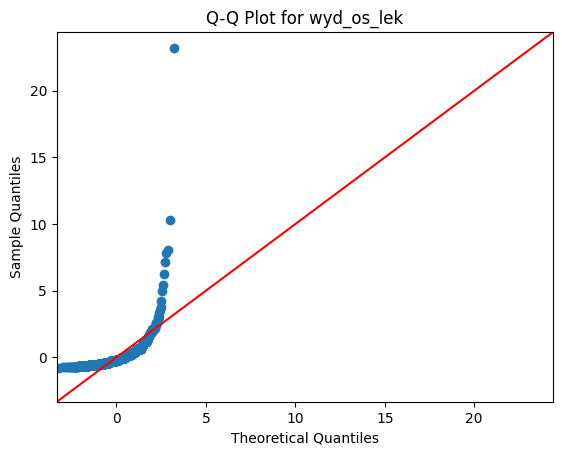

In [21]:
###############################################################
# 5. Analiza danych – testy normalności i diagnostyka         #
###############################################################

def test_normality(series, col_name):
    """
    Wykonuje testy normalności dla podanej serii danych oraz generuje Q-Q plot.
    """
    values = series.dropna()
    # Test Shapiro-Wilka
    shapiro_stat, shapiro_p = shapiro(values)
    
    # Test Andersona-Darlinga
    anderson_result = anderson(values, dist='norm')
    
    # Test D'Agostino-Pearsona
    dagostino_stat, dagostino_p = normaltest(values)
    
    print(f"\nNormality tests for {col_name}:")
    print(f"Shapiro-Wilk: stat = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
    print(f"Anderson-Darling: stat = {anderson_result.statistic:.4f}")
    print(f"D'Agostino-Pearson: stat = {dagostino_stat:.4f}, p = {dagostino_p:.4f}")
    
    # Generowanie Q-Q plot
    sm.qqplot(values, line='45', fit=True)
    plt.title(f"Q-Q Plot for {col_name}")
    plt.show()

# Przykładowe wywołanie testu na kolumnie 'wyd_os_lek'
test_normality(model2['wyd_os_lek'], 'wyd_os_lek')

In [22]:
#############################################
# 6. Modelowanie statystyczne             #
#############################################

# Przygotowanie zmiennej zależnej - obliczamy logarytm z wydatków
model2['log_wydatki'] = np.log(model2['wyd_os_lek'])

# Przygotowanie macierzy predyktorów
# Załóżmy, że w modelu wykorzystamy zmienne: 'dochod_los', 'liczba_osob' oraz 'inwalidztwo'
predictors = ['dochod_los', 'liczba_osob', 'inwalidztwo']
X = model2[predictors]
X = sm.add_constant(X)  # Dodanie stałej do modelu

# Zmienna zależna
y = model2['log_wydatki']

# Budowa modelu OLS
model = sm.OLS(y, X).fit()
print("Podstawowy model OLS:")
print(model.summary())

# Budowa modelu OLS z heteroskedastycznymi błędami (robust standard errors)
robust_model = model.get_robustcov_results(cov_type='HC0')
print("\nModel OLS z heteroskedastycznymi błędami (HC0):")
print(robust_model.summary())

# Przykładowe testy diagnostyczne
# Influence Plot
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.influence_plot(model, ax=ax, criterion='cooks')
plt.title('Influence Plot')
plt.show()

# Obliczenie VIF (Variance Inflation Factor) dla oceny multikolinearności
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif)

KeyError: "['dochod_los'] not in index"

In [ ]:
#############################################
# 7. Wizualizacje i raportowanie          #
#############################################

# Residuals vs Fitted Plot
fitted_vals = model.fittedvalues
residuals = model.resid
plt.figure(figsize=(8,6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Q-Q Plot of Residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Influence Plot
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.influence_plot(model, ax=ax, criterion='cooks')
plt.title('Influence Plot')
plt.show()

## Wnioski i rekomendacje

Podsumowując przeprowadzoną analizę:
- Model OLS wykazał statystycznie istotny wpływ wybranych zmiennych na logarytm wydatków.
- Testy normalności sugerują, że reszty modelu nie są w pełni zgodne z założeniem normalności, co można zauważyć na Q-Q Plot.
- Wizualizacje (Residuals vs Fitted, Influence Plot) wykazują obecność potencjalnych obserwacji odstających, które mogą wpłynąć na wyniki modelowania.

**Rekomendacje:**
- Przeprowadzić dalsze badania diagnostyczne, np. użyć regresji odpornej (robust regression) lub usunąć obserwacje odstające.
- Rozważyć transformację zmiennych lub zastosowanie metod nieparametrycznych, gdy założenia modelu OLS nie są spełnione.
- Wprowadzić walidację krzyżową w celu oceny stabilności modelu.
- Zastosować dodatkowe testy diagnostyczne, takie jak VIF, aby ocenić multikolinearność.